In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scr
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


In [15]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Pre-HVG processing

1 and 2 refer to the biological replicates, a and b refer to technical.


* Read in each age and concatenate its batches into one object.
* After having 6 object, one for each age, concatenate those with
```
adata = age_objs[0].concatenate(age_objs[1], age_objs[2], age_objs[3], age_objs[4], age_objs[5], batch_categories=['P8', 'P14', P17', 'P21', 'P28', 'P38'])
```

In [3]:
base_path = '/path/to/mouse visual cortex/'
age_id = ['P8', 'P14', 'P17', 'P21', 'P28', 'P38']
age_objs = []
sample_size = []

for i in range(len(age_id)-1):
    oneA = sc.read_10x_mtx(base_path + age_id[i] + '_nr_1_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
    oneB = sc.read_10x_mtx(base_path + age_id[i] + '_nr_1_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
    twoA = sc.read_10x_mtx(base_path + age_id[i] + '_nr_2_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)
    twoB = sc.read_10x_mtx(base_path + age_id[i] + '_nr_2_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=False)

    age_objs.append(oneA.concatenate(oneB, twoA, twoB, batch_categories=[age_id[i] + '_1a', age_id[i] + '_1b', 
                                                               age_id[i] + '_2a', age_id[i] + '_2b']))
    
    sample_size.append(oneA.shape[0])
    sample_size.append(oneB.shape[0])
    sample_size.append(twoA.shape[0])
    sample_size.append(twoB.shape[0])

    print('Finished ', age_id[i])

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Finished  P8
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Finished  P14
--> This might be very slow. Consider passing `cache=True`, which ena

For P38.

In [4]:
sample_size_P38 = []

i=5
oneA = sc.read_10x_mtx(base_path + age_id[i] + '_nr_1_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
#oneB = sc.read_10x_mtx(base_path + age_id[i] + '_nr_1_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
twoA = sc.read_10x_mtx(base_path + age_id[i] + '_nr_2_a/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)
twoB = sc.read_10x_mtx(base_path + age_id[i] + '_nr_2_b/filtered_feature_bc_matrix', var_names='gene_symbols', cache=True)

age_objs.append(oneA.concatenate(twoA, twoB, batch_categories=[age_id[i] + '_1a', 
                                                               age_id[i] + '_2a', age_id[i] + '_2b']))

sample_size_P38.append(oneA.shape[0])
sample_size_P38.append(twoA.shape[0])
sample_size_P38.append(twoB.shape[0])

print('Finished ', age_id[i])

... writing an h5ad cache file to speedup reading next time
... reading from cache file cache/Volumes-GoogleDrive-My Drive-mouse visual cortex-P38_nr_2_a-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/Volumes-GoogleDrive-My Drive-mouse visual cortex-P38_nr_2_b-filtered_feature_bc_matrix-matrix.h5ad
Finished  P38


In [6]:
adata = age_objs[0].concatenate(age_objs[1], age_objs[2], age_objs[3], age_objs[4], age_objs[5], 
                                batch_categories=['P8', 'P14', 'P17', 'P21', 'P28', 'P38'])

In [1]:
sc.pp.filter_cells(adata, min_genes=700) #cell must have 700 non-zero-count features to stay
sc.pp.filter_genes(adata, min_cells=8) #gene must be in 8 cells to stay

NameError: name 'sc' is not defined

In [8]:
mito_genes = adata.var_names.str.startswith('mt-') #boolean array denoting if a gene is mito

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

# add each cell's fraction mito accounts as an obs annotation
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Visualize count matrix before filtering

... storing 'feature_types' as categorical


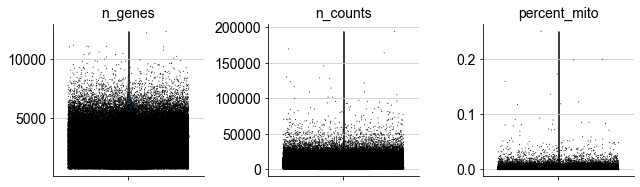

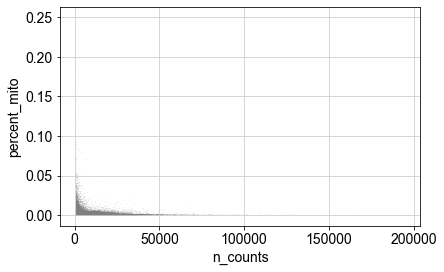

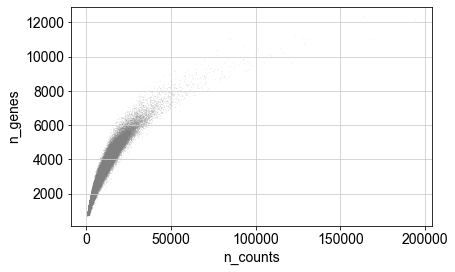

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Very few cells with about 1-2% mito counts. Remove those above 1%. Remove cells with more than 30,000 counts and more than 6500 non-zero counts.

In [10]:
adata = adata[adata.obs.percent_mito < 0.01, :]
adata = adata[adata.obs['n_genes'] < 6500, :]
adata = adata[adata.obs['n_counts'] < 40000, :]

Peek after

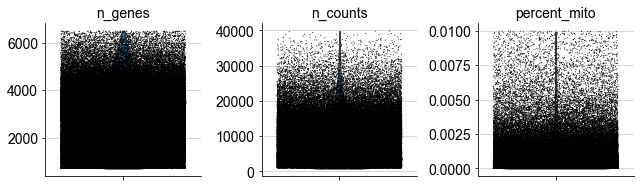

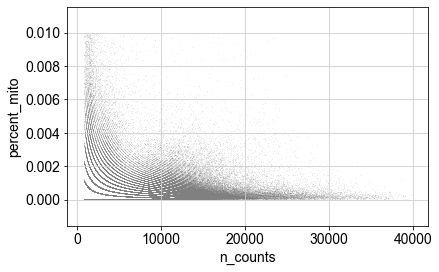

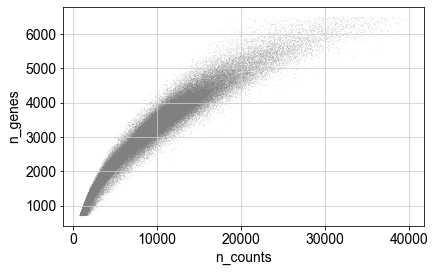

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata

View of AnnData object with n_obs × n_vars = 167384 × 30869 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:24): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [14]:
adata.raw = adata #store pre-scale counts

Save pre-HVGs object for analysis on Savio.

In [18]:
adata.write_h5ad('PooledMVC_preHVG.h5ad')

In [4]:
adata = sc.read_h5ad('/path/to/PooledMVC_preHVG.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 167384 × 30869 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [ ]:
#code for HVG to clustering
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
import scanorama

sc.settings.verbosity = 3 

#-------PCA clustering------------#
adata = sc.read_h5ad('PooledMVC_preHVG.h5ad')

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(adata, max_value=10) #scale

sc.tl.pca(adata, svd_solver='arpack') #run PCA
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40) #choose 25 standard for now
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.write_h5ad('PooledMVC_clusteredPCA.h5ad')

# Post-clustering analysis

## Clustering workflow

Generates `PooledMVC_clusteredPCA.h5ad`

In [ ]:
#code
sc.settings.verbosity = 3 

adata = sc.read_h5ad('PooledMVC_preHVG.h5ad')

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(adata, max_value=10) #scale

sc.tl.pca(adata, svd_solver='arpack') #run PCA
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40) #choose 25 standard for now
sc.tl.leiden(adata)
sc.tl.umap(adata)

adata.write_h5ad('PooledMVC_clusteredPCA.h5ad')

In [ ]:
#code for subclass markers
non_markers = ['Aqp4', 'Aldoc', 'Aldh1l1', 'S100b',
              'Pdgfra',
              'Enpp6',
              'Dcn', 'Bgn', 'Aox3', 'Osr1', 'Lum', 'Col1a1',
              'Kcnj8', 'Abcc9', 'Art3', 'Acta2',
              'Cspg4', 'Acta2', 'Angpt1', 'Des',
              'Pdgfb', 'Nos3', 'Pecam1', 'Tek',
              'Mrc1', 'Lyve1', 'Cd163', 'Cd4', 'Lyz2',
              'Tmem119', 'Ctss', 'Cx3cr1']
sc.pl.dotplot(adata, non_markers, groupby='leiden', dendrogram=True, save='_non-neuron_pca.pdf')

glut_markers = ['Slc17a7', 'Snap25',
               'Cux2', 'Rorb', 'Mdga1',
               'Deptor', 'Rbp4', 'Batf3',
               'Osr1', 'Cdh9',
               'Bcl6', 'Fam84b', 'Foxp2',
               'Slc17a8', 'Trhr', 'Sla2', 'Rapgef3',
               'Ctgf', 'Nxph4', 'Inpp4b']
glut_pos = [(0,1), (2,4), (5,7), (8,9), (10,12), (13,16), (17,19)]
glut_labels = ['General', 'Layer 2/3/4 IT', 'Layer 5 IT', 'Layer 6 IT', 'Layer 5  PT','Layer 5 NP', 'Layer  6 CT/6b']

sc.pl.dotplot(adata, glut_markers, groupby='leiden', dendrogram=True, var_group_positions=glut_pos, var_group_labels=glut_labels, var_group_rotation='45', save='_gluta_pca.pdf')

gaba_markers = ['Gad1', 'Gad2',
                'Sst', 'Cpne5',
                'Tac1', 'Pvalb',
                'Vip', 'Pax6', 'Tmem182', 'Plch2', 'Dock5', 'Krt73',
                'Lamp5', 'Pax6',
                'Slc17a8', 'Serpinf1']

sc.pl.dotplot(adata, gaba_markers, groupby='leiden', dendrogram=True, save='_gaba_pca.pdf')

## Doublet detection

In `DoubletDetection.ipynb`, run each sample separately, merge all, then `adata.write_h5ad('PooledMVC_dubs.h5ad')`

Then run the following code.

Generates `PooledMVC_clusteredPCA_dubs.h5ad`

In [ ]:
#original code

adata = sc.read_h5ad('PooledMVC_clusteredPCA.h5ad')

'''
x_pos = ['Ambig_1', 'Astro_1', 'Ambig_2', 'Astro_2', 'Astro_3', 
         'OD_1', 'OD_2',
        'Ambig_3',
        'OPC_1', 'OPC_2',
        'Micro',
        'Ambig_4', 'Ambig_5',
         'Endo',
         'VLMC_1', 'VLMC_2',
         'Inh_1', 'Inh_2', 'Inh_3', 'Inh_4',
         'Ambig_6', 'Ambig_7', 'Exc_1', 'Ambig_8', 'Exc_2', 'Exc_3',
         'Ambig_9', 'Exc_4', 'Exc_5', 'Exc_6', 'Exc_7', 'Exc_8',
         'Ambig_10', 'Exc_9', 'Exc_10', 'Exc_11', 'Exc_12', 'Exc_13', 'Exc_14', 'Exc_15', 'Exc_16', 'Exc_17']   
'''
x_pos = [41, 30, 27, 6, 15, 11, 22, 36, 7, 40, 10, 31, 23, 34, 37, 26, 5, 39, 9, 38, 18, 14, 33, 25, 3, 1, 29, 24, 35, 17, 21, 32, 16, 28, 19, 0, 13, 12, 20, 4, 2, 8]

doublet_perc = []
means = []
SDs = []
ticks= []
for i in x_pos:
    current_clust = adata[adata.obs.leiden==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)
    means.append(np.mean(current_clust.obs['Doublet Score']))
    SDs.append(np.std(current_clust.obs['Doublet Score']))
    ticks.append(i)

x_pos = ticks


fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, means, yerr=SDs, align='center', alpha=0.5, ecolor='black', capsize=5, color='blue', width=0.75)
ax.set_ylabel('Doublet Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='45')
ax.set_title('Doublet scores for each cluster')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')

plt.tight_layout()
plt.savefig('figures/DoubletScores.pdf')

fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='90')
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()
plt.savefig('figures/DoubletPercents.pdf')


dubs = sc.read_h5ad('MVC_h5ad_files/PooledMVC_dubs.h5ad')

#adata_cells = list(adata.obs.index)
#dubs_cells = list(dubs.obs.index)
#subset_cells = list(set.intersection(set(adata_cells),set(dubs_cells)))
adata_dubs = adata[list(dubs.obs.index), :]


#check cell algignment b/w merged doublet object and clustered object
problem = []
for i in range(adata_dubs.shape[0]):
    if(adata_dubs.obs.index[i] != dubs.obs.index[i]):
        problem.append(adata_dubs.obs.index[i])

print(len(problem))

adata_dubs.obs['Doublet'] = dubs.obs['Doublet']
adata_dubs.obs['Doublet Score'] = dubs.obs['Doublet Score']

sc.pl.umap(adata_dubs, color=['Doublet','leiden', 'Doublet Score'], legend_loc='on data', legend_fontsize='6' , save = '_DoubletView.pdf')

adata_dubs.write_h5ad('PooledMVC_clusteredPCA_dubs.h5ad')

sc.pl.umap(adata, color=['Doublet','cluster', 'Doublet Score'], 
        legend_loc='on data', legend_fontsize='6', save = '_DoubletView.pdf')

In [ ]:
#code for refining Figure S1 plot

adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')

x_pos = adata.uns["dendrogram_['cluster']"]['dendrogram_info']['ivl']

doublet_perc = []
means = []
SDs = []
for i in x_pos:
    current_clust = adata[adata.obs.cluster==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)
    means.append(np.mean(current_clust.obs['Doublet Score']))
    SDs.append(np.std(current_clust.obs['Doublet Score']))



fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, means, yerr=SDs, align='center', alpha=0.5, ecolor='black', capsize=5, color='blue', width=0.75)
ax.set_ylabel('Doublet Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='45')
ax.set_title('Doublet scores for each cluster')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_xlabel('Cluster')

plt.tight_layout()
plt.savefig('figures/DoubletScores.pdf')

fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Percentage')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='90')
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(True)
ax.xaxis.grid(False)
#ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()
plt.savefig('figures/DoubletPercents.pdf')


## Rename clusters and plot umap: leiden, age, class and dotplot: main markers

Ambig_# clusters that don't have high doublet fraction are removed for other reasons like low expression of class. That's only C16, because low Cux2/Rorb/any other gluta markers.

Generates `PooledMVC_clusteredPCA_dubs_classes.h5ad`

In [ ]:
#original code

adata_read = sc.read_h5ad('/global/scratch/salwan/MVC/MVC_h5ad_files/PooledMVC_clusteredPCA_dubs.h5ad')


#remove a miniscule cluster 
adata = adata_read[adata_read.obs['leiden']!='42',:]

print(" ")
print(adata.obs.leiden)


#42 cluster names
cluster_dict = {0:'Exc_13',  1:'Exc_5',  2:'Exc_18',  3:'Exc_4',  
                4:'Exc_17',  5:'Exc_2',  6:'Astro_2',  7:'OPC_1',  8:'Exc_19',  9:'Inh_2', 
                10:'Micro', 11:'OD_1', 12:'Exc_15', 13:'Exc_14', 14:'Inh_5', 15:'Astro_3', 16:'Ambig_7',
                17:'Exc_8', 18:'Inh_4', 19:'Exc_12', 20:'Exc_16', 21:'Exc_9', 
                22:'OD_2', 23:'Endo', 24:'Exc_6', 25:'Inh_1', 26:'Exc_1', 27:'Ambig_2', 
                28:'Exc_11', 29:'Ambig_6', 30:'Astro_1', 31:'Ambig_4', 32:'Exc_10', 33:'Ambig_5',
                34:'VLMC_1', 35:'Exc_7', 36:'Ambig_3', 37:'VLMC_2', 38:'Inh_3', 39:'Exc_3', 
                40:'OPC_2', 41:'Ambig_1'}
cluster = []
for i in range(len(cluster_dict)): cluster.append((cluster_dict[i]))

adata.obs['cluster'] = adata.obs['leiden']
adata.rename_categories(key='cluster', categories=cluster)


#major class names
Class_broad = []
for i in range(adata.shape[0]):
    if (int(adata.obs['leiden'][i]) in (30, 6, 15)): Class_broad.append('Astrocytes')
    elif (int(adata.obs['leiden'][i]) in (11, 22)): Class_broad.append('Oligodendrocytes')
    elif (int(adata.obs['leiden'][i]) in (7, 40)): Class_broad.append('OPCs')
    elif (int(adata.obs['leiden'][i]) in (10, 4000)): Class_broad.append('Microglia')
    elif (int(adata.obs['leiden'][i]) in (23, 4000)): Class_broad.append('Endothelial')
    elif (int(adata.obs['leiden'][i]) in (34, 37)): Class_broad.append('VLMC')
    elif (int(adata.obs['leiden'][i]) in (25, 9, 38, 18, 14)): Class_broad.append('Inhibitory')
    elif (int(adata.obs['leiden'][i]) in (16, 27, 29, 31, 33, 36, 41)): Class_broad.append('Ambiguous')  
    else: Class_broad.append('Excitatory')

        
adata.obs['Class_broad'] = adata.obs['leiden']
adata.obs['Class_broad'] = Class_broad


print("")
print("This is adata after adding classes")
print(adata.obs)

#sc.pl.umap(adata, color=['Class_broad'], title='', frameon=False,  save='_Classes_broad.pdf')



#sc.tl.dendrogram(adata, groupby='Class')
#sc.settings.set_figure_params(dpi=200)

#astro, ODs+ OPCs, ODs_1, ODs_2, OPCs, Microglia, Endo, VLMC_1, VLMC_2, GABA, Gluta, Neurons
leiden_markers = ['Aldh1l1', 'Mog', 'Enpp6', 'Pdgfra', 'Sox10', 
                       'Cx3cr1', 'Pecam1', 'Slc47a1', 'Slc6a13', 'Gad1', 'Gad2', 'Slc17a7', 'Snap25']

#sc.pl.dotplot(adata, leiden_markers, groupby='cluster', dendrogram=True, save='_Markers_leiden.pdf')


#sc.pl.umap(adata, color='cluster', title='', frameon=False, legend_loc='on data', legend_fontsize='6', save='_leiden.pdf')

#sc.pl.umap(adata, color='batch', title='Age', frameon=False, legend_fontsize='10', save='_age.pdf')


adata.write_h5ad('/global/scratch/salwan/MVC/MVC_h5ad_files/PooledMVC_clusteredPCA_dubs_classes.h5ad')

In [ ]:
#code for refining plots

adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')


cluster_cols = (sns.color_palette('pastel').as_hex()+sns.color_palette('Set2').as_hex()+sns.color_palette('Set3').as_hex()+sns.color_palette('hls').as_hex()+sns.color_palette('husl').as_hex())

sc.pl.umap(adata, color=['Class_broad'], title=str(adata.shape[0]) + ' cells',
           palette = sns.color_palette('Set1').as_hex()+sns.color_palette('Set2').as_hex(),
           add_outline=True,
           save='_Classes_broad.pdf')

sc.pl.umap(adata, color='leiden', title='', legend_loc='on data', 
           legend_fontsize='7', palette=cluster_cols, add_outline=True, 
           save='_leiden.pdf')

sc.pl.umap(adata, color='batch', title='Age', legend_fontsize='10',
            add_outline=True,
            save='_age.pdf')

sc.pl.umap(adata, color='Doublet', legend_loc='on data', legend_fontsize='6', 
        add_outline=True,
        save = '_DoubletsColor.pdf')

leiden_markers = ['Aldh1l1', 'Mog', 'Enpp6', 'Pdgfra', 'Sox10', 
                       'Cx3cr1', 'Pecam1', 'Slc47a1', 'Slc6a13', 
                       'Cux2','Ccbe1','Rorb','Whrn', 'Deptor', 'Tshz2', 'Bcl6', 'Foxp2', 'Cdh9', 'Inpp4b',
                       'Pvalb','Syt2', 'Unc13c', 'Vip', 'Sema5b', 'Lamp5', 'Sv2c', 'Stac', 'Frem1', 
                       'Gad1', 'Gad2', 'Slc17a7', 'Snap25']


leiden_markers = ['Cx3cr1', 'Mog',  'Pdgfra', 'Aldh1l1',  'Pecam1', 'Slc47a1', 
                  'Snap25',
                  'Gad1', 'Vip', 'Pvalb', 'Sst',  'Lamp5',
                  'Slc17a7', 'Cux2','Rorb', 'Deptor', 'Tshz2', 'Bcl6', 'Foxp2', 'Cdh9']

from matplotlib.colors import ListedColormap
mapcol = ListedColormap(sns.color_palette('light:#a31fe7', n_colors=100).as_hex())

sc.pl.dotplot(adata, leiden_markers, groupby='cluster', dendrogram=True,
        dot_max=0.8, vmax=2,cmap = mapcol, save= 'Markers_cluster.pdf')




## Name layers and subclasses

In [ ]:
adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')


subclass = []

for i in range(adata.shape[0]):
    if (adata.obs['cluster'][i] in ['Exc_1', 'Exc_2', 'Exc_17', 'Exc_18', 'Exc_19']):
        subclass.append('L2/3')
        
    elif(adata.obs['cluster'][i] in ['Exc_3', 'Exc_12', 'Exc_13', 'Exc_14', 'Exc_16']):
        subclass.append('L4')
        
    elif(adata.obs['cluster'][i] in ['Exc_8', 'Exc_9', 'Exc_15']):
        subclass.append('L5')
    
    elif(adata.obs['cluster'][i] in ['Exc_4', 'Exc_5', 'Exc_6', 'Exc_7', 'Exc_10', 'Exc_11']):
        subclass.append('L6')
        
    elif(adata.obs['cluster'][i] in ['Ambig_1', 'Ambig_2','Ambig_3','Ambig_4','Ambig_5','Ambig_6','Ambig_7']):
        subclass.append('Ambig')
        
    elif(adata.obs['cluster'][i] in ['Astro_1', 'Astro_2', 'Astro_3']):
        subclass.append('Astro')
        
    elif(adata.obs['cluster'][i] in ['OD_1', 'OD_2']):
        subclass.append('OD')
        
    elif(adata.obs['cluster'][i] in ['OPC_1', 'OPC_2']):
        subclass.append('OPC')
        
    elif(adata.obs['cluster'][i] in ['VLMC_1', 'VLMC_2']):
        subclass.append('VLMC')
        
    elif(adata.obs['cluster'][i] in ['Inh_1', 'Inh_3']):
        subclass.append('Inh')
        
    elif(adata.obs['cluster'][i] =='Micro'):
        subclass.append('Micro')
   
    elif(adata.obs['cluster'][i] =='Endo'):
        subclass.append('Endo')

    elif(adata.obs['cluster'][i] =='Inh_5'):
        subclass.append('Pvalb')
        
    elif(adata.obs['cluster'][i] =='Inh_4'):
        subclass.append('Sst')  
        
    elif(adata.obs['cluster'][i] =='Inh_2'):
        subclass.append('Vip')
        
        
adata.obs['Subclass'] = pd.Categorical(subclass)

adata.write_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')


In [ ]:
adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')

sc.tl.dendrogram(adata, groupby='Subclass')

x_pos = adata.uns["dendrogram_['Subclass']"]['dendrogram_info']['ivl']

doublet_perc = []
means = []
SDs = []
for i in x_pos:
    current_clust = adata[adata.obs.Subclass==i, :]
    doublet_perc.append((current_clust[current_clust.obs.Doublet,:].shape[0]/current_clust.shape[0])*100)
    means.append(np.mean(current_clust.obs['Doublet Score']))
    SDs.append(np.std(current_clust.obs['Doublet Score']))



fig, ax = plt.subplots(figsize=(24,9))
ax.bar(x_pos, means, yerr=SDs, align='center', alpha=0.5, ecolor='black', capsize=5, color='blue', width=0.75)
ax.set_ylabel('Doublet Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos, rotation='45')
ax.set_title('Doublet scores for each cluster')
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.set_xlabel('Subclass')

plt.tight_layout()
plt.savefig('figures/DoubletScores.pdf')

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x_pos, doublet_perc, color='blue', width=0.75)
ax.set_ylabel('Doublet Percentage')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
#ax.set_title('Percentage of doublets')
ax.yaxis.grid(False)
ax.xaxis.grid(False)
#ax.set_xlabel('Cluster')
# Save the figure and show
plt.tight_layout()
plt.savefig('figures/DoubletPercents.pdf')

## Cluster size fraction

In [ ]:
#code
adata = sc.read_h5ad('/global/scratch/salwan/MVC/MVC_h5ad_files/PooledMVC_clusteredPCA_dubs_classes.h5ad')

x_pos = list(adata.obs.cluster.values.categories)

total_cells = adata.shape[0]
cell_fraction = []
cell_count = []

for i in x_pos:
    cell_fraction.append(adata[adata.obs.cluster==i, :].shape[0]*100/total_cells)
    cell_count.append(adata[adata.obs.cluster==i, :].shape[0])



fig, ax = plt.subplots(figsize=(20,6))

right_side = ax.spines["right"]
top = ax.spines["top"]
bottom = ax.spines["bottom"]

right_side.set_visible(False)
top.set_visible(False)
bottom.set_visible(False)

plt.bar(x_pos, cell_fraction, color = adata.uns['cluster_colors'], edgecolor = 'black', linewidth=1)
plt.grid(False)
plt.xticks(rotation='90', fontsize='10')
plt.yticks(fontsize ='12')

#plt.xlabel('Cluster', rotation='180')
plt.ylabel('Percentage of cells')

#axs.set_yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000])

fig.savefig('cluster_fraction.pdf')


'''
plt.bar(x_pos, cell_fraction, color='blue')
plt.grid(axis='x')
plt.xlabel('Cluster')
plt.ylabel('Percent of total cells')
plt.savefig('cluster_percent.pdf')


plt.bar(x_pos, cell_count, color='blue')
plt.grid(axis='x')
plt.xlabel('Cluster')
plt.ylabel('Number of cells')
plt.xticks(x_pos)
plt.savefig('cluster_size.pdf')
'''

## Cluster and class distribution across ages

New version

In [ ]:
#code 

import scanpy as sc
import os
import matplotlib.pyplot as plt
import numpy as np

stream = os.popen("export HDF5_USE_FILE_LOCKING='FALSE' ")

sc.settings.set_figure_params(dpi=200)

#code

import scanpy as sc
import os
import matplotlib.pyplot as plt
import numpy as np

stream = os.popen("export HDF5_USE_FILE_LOCKING='FALSE' ")

adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')
print('~~~~~Finished reading PooledMVC_clusteredPCA_dubs_classes.h5ad~~~~~~~')
print(adata)
        
sc.settings.set_figure_params(dpi=200)


# stacked bar plot
#Get values from the group and categories

astro_s = []
od_s = []
opc_s = []
mg_s = []
endo_s = []
vlmc_s = []
inhib_s = []
exc_s = []
ambig_s = []

x_pos = ['P8', 'P14', 'P17', 'P21', 'P28', 'P38']
ages = ['Astrocytes', 'Oligodendrocytes', 'OPCs', 'Microglia', 
        'Endothelial', 'VLMC', 'Inhibitory', 'Excitatory', 'Ambiguous']

for i in x_pos:
    current_clust = adata[adata.obs.batch==i,:]
    
    astro_s.append(current_clust[current_clust.obs.Class_broad=='Astrocytes',:].shape[0])
    od_s.append(current_clust[current_clust.obs.Class_broad=='Oligodendrocytes',:].shape[0])
    opc_s.append(current_clust[current_clust.obs.Class_broad=='OPCs',:].shape[0])
    mg_s.append(current_clust[current_clust.obs.Class_broad=='Microglia',:].shape[0])
    endo_s.append(current_clust[current_clust.obs.Class_broad=='Endothelial',:].shape[0])
    vlmc_s.append(current_clust[current_clust.obs.Class_broad=='VLMC',:].shape[0])
    inhib_s.append(current_clust[current_clust.obs.Class_broad=='Inhibitory',:].shape[0])
    exc_s.append(current_clust[current_clust.obs.Class_broad=='Excitatory',:].shape[0])
    ambig_s.append(current_clust[current_clust.obs.Class_broad=='Ambiguous',:].shape[0])


        
cluster = np.array(x_pos)


astro = np.array(astro_s)
od = np.array(od_s)
opc = np.array(opc_s)
mg = np.array(mg_s)
endo = np.array(endo_s)
vlmc = np.array(vlmc_s)
inhib = np.array(inhib_s)
exc = np.array(exc_s)
ambig = np.array(ambig_s)



total = astro+od+opc+mg+endo+vlmc+inhib+exc+ambig
proportion_astro = np.true_divide(astro, total) * 100
proportion_od = np.true_divide(od, total) * 100
proportion_opc = np.true_divide(opc, total) * 100
proportion_mg = np.true_divide(mg, total) * 100
proportion_endo = np.true_divide(endo, total) * 100
proportion_vlmc = np.true_divide(vlmc, total) * 100
proportion_inhib = np.true_divide(inhib, total) * 100
proportion_exc = np.true_divide(exc, total) * 100
proportion_ambig = np.true_divide(ambig, total) * 100


#add colors
cols = adata.uns['Class_broad_colors']
colors = [cols[1], cols[7], cols[6], cols[5], cols[2], cols[8], cols[4], cols[3], cols[0]]


# The position of the bars on the x-axis
r = range(len(cluster))
barWidth = 0.5
#plot bars
plt.figure(figsize=(20,7))
ax1 = plt.bar(r, proportion_astro, bottom=proportion_od+proportion_opc+proportion_mg+proportion_endo+proportion_vlmc+proportion_inhib+proportion_exc+proportion_ambig, 
              color=colors[0], edgecolor='white', width=barWidth, label="Astrocytes")

ax2 = plt.bar(r, proportion_od, bottom=proportion_opc+proportion_mg+proportion_endo+proportion_vlmc+proportion_inhib+proportion_exc+proportion_ambig, 
              color=colors[1], edgecolor='white', width=barWidth, label='Oligodendrocytes')

ax3 = plt.bar(r, proportion_opc, bottom=proportion_mg+proportion_endo+proportion_vlmc+proportion_inhib+proportion_exc+proportion_ambig, 
              color=colors[2], edgecolor='white', width=barWidth, label='OPCs')

ax4 = plt.bar(r, proportion_mg, bottom=proportion_endo+proportion_vlmc+proportion_inhib+proportion_exc+proportion_ambig, 
              color=colors[3], edgecolor='white', width=barWidth, label='Microglia')

ax5 = plt.bar(r, proportion_endo, bottom=proportion_vlmc+proportion_inhib+proportion_exc+proportion_ambig,
              color=colors[4], edgecolor='white', width=barWidth, label='Endothelial')

ax6 = plt.bar(r, proportion_vlmc, bottom=proportion_inhib+proportion_exc+proportion_ambig,
              color=colors[5], edgecolor='white', width=barWidth, label='VLMCs')

ax7 = plt.bar(r, proportion_inhib, bottom=proportion_exc+proportion_ambig,
              color=colors[6], edgecolor='white', width=barWidth, label='Inhibitory')

ax8 = plt.bar(r, proportion_exc, bottom=proportion_ambig,
              color=colors[7], edgecolor='white', width=barWidth, label='Excitatory')

ax9 = plt.bar(r, proportion_ambig, color=colors[8], edgecolor='white', width=barWidth, label='Ambiguous')

plt.legend(ncol=9, bbox_to_anchor=(0, 1), loc='lower left')

plt.xticks(r, cluster, rotation='30')
plt.ylabel("Percentage of Cells")
plt.xlabel("Cluster")
plt.grid(False)
plt.savefig('age_fraction_class_110522.pdf')

################################################################

P8_s = []
P14_s = []
P17_s = []
P21_s = []
P28_s = []
P38_s = []

x_pos = list(adata.uns["dendrogram_['cluster']"]['dendrogram_info']['ivl'])


ages = ['P8', 'P14', 'P17', 'P21', 'P28', 'P38']

for i in x_pos:
    current_clust = adata[adata.obs.cluster==i,:]
    P8_s.append(current_clust[current_clust.obs.batch=='P8',:].shape[0])
    P14_s.append(current_clust[current_clust.obs.batch=='P14',:].shape[0])
    P17_s.append(current_clust[current_clust.obs.batch=='P17',:].shape[0])
    P21_s.append(current_clust[current_clust.obs.batch=='P21',:].shape[0])
    P28_s.append(current_clust[current_clust.obs.batch=='P28',:].shape[0])
    P38_s.append(current_clust[current_clust.obs.batch=='P38',:].shape[0])
        
cluster = np.array(x_pos)


P8 = np.array(P8_s)
P14 = np.array(P14_s)
P17 = np.array(P17_s)
P21 = np.array(P21_s)
P28 = np.array(P28_s)
P38 = np.array(P38_s)


total = P8+ P14+ P17+P21+P28+P38
proportion_P8 = np.true_divide(P8, total) * 100
proportion_P14 = np.true_divide(P14, total) * 100
proportion_P17 = np.true_divide(P17, total) * 100
proportion_P21 = np.true_divide(P21, total) * 100
proportion_P28 = np.true_divide(P28, total) * 100
proportion_P38 = np.true_divide(P38, total) * 100


#add colors
cols = adata.uns['batch_colors']
colors = [cols[0], cols[1], cols[2], cols[3], cols[4], cols[5]]

# The position of the bars on the x-axis
r = range(len(cluster))
barWidth = 0.5
#plot bars
plt.figure(figsize=(30,8))
ax1 = plt.bar(r, proportion_P8, bottom=proportion_P14+proportion_P17+proportion_P21+proportion_P28+proportion_P38, color=colors[0], edgecolor='white', width=barWidth, label="P8")
ax2 = plt.bar(r, proportion_P14, bottom=proportion_P17+proportion_P21+proportion_P28+proportion_P38, color=colors[1], edgecolor='white', width=barWidth, label='P14')
ax3 = plt.bar(r, proportion_P17, bottom=proportion_P21+proportion_P28+proportion_P38, color=colors[2], edgecolor='white', width=barWidth, label='P17')
ax4 = plt.bar(r, proportion_P21, bottom=proportion_P28+proportion_P38, color=colors[3], edgecolor='white', width=barWidth, label='P21')
ax5 = plt.bar(r, proportion_P28, bottom=proportion_P38,color=colors[4], edgecolor='white', width=barWidth, label='P28')
ax6 = plt.bar(r, proportion_P38, color=colors[5], edgecolor='white', width=barWidth, label='P38')

plt.legend(loc='best', fontsize='x-large')
plt.xticks(r, cluster, rotation='90')
plt.ylabel("Percentage of Cells")
#plt.xlabel("Cluster")
plt.grid(axis='x')
plt.savefig('age_fraction_110522.pdf')

## Remove clusters with majority doublet fraction, then all cells marked as doublets by Scrublet

Generates `PooledMVC_clusteredPCA_dubs_classes_clean.h5ad` with 147236 to carry forward.

In [ ]:
#code
adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes.h5ad')

print('object before removing doublets clusters')
print(adata)

adata = adata[adata.obs['cluster']!='Ambig_1',:]
adata = adata[adata.obs['cluster']!='Ambig_2',:]
adata = adata[adata.obs['cluster']!='Ambig_3',:]
adata = adata[adata.obs['cluster']!='Ambig_4',:]
adata = adata[adata.obs['cluster']!='Ambig_5',:]
adata = adata[adata.obs['cluster']!='Ambig_6',:]
adata = adata[adata.obs['cluster']!='Ambig_7',:]


adata = adata[adata.obs['Doublet'] == False,:]

print('object after removing doublets clusters')
print(adata)

adata.write_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes_clean.h5ad')
print("num of cells: ", adata.shape[0])

## Sample distribution barplot

In [ ]:
adata = sc.read_h5ad('gluta_gaba_glia_combined_analyzed.h5ad')

a = {}
for i in adata.obs['sample'].values.categories:
    samp = adata[adata.obs['sample']==i,:]
    counts = samp.obs.Class.value_counts(normalize=True)
    a[i] = [counts['Excitatory'], counts['Inhibitory'], counts['Non-neuron']]
    
barplot_df = pd.DataFrame(a, index=['Excitatory', 'Inhibitory', 'Non-neuron']).transpose()

barplot_df.to_csv('samples_barplot.csv')

In [3]:
barplot_df = pd.read_csv('/path/to/samples_barplot.csv')

In [12]:
barplot_df.index = barplot_df['Unnamed: 0'].values

In [14]:
del barplot_df['Unnamed: 0']

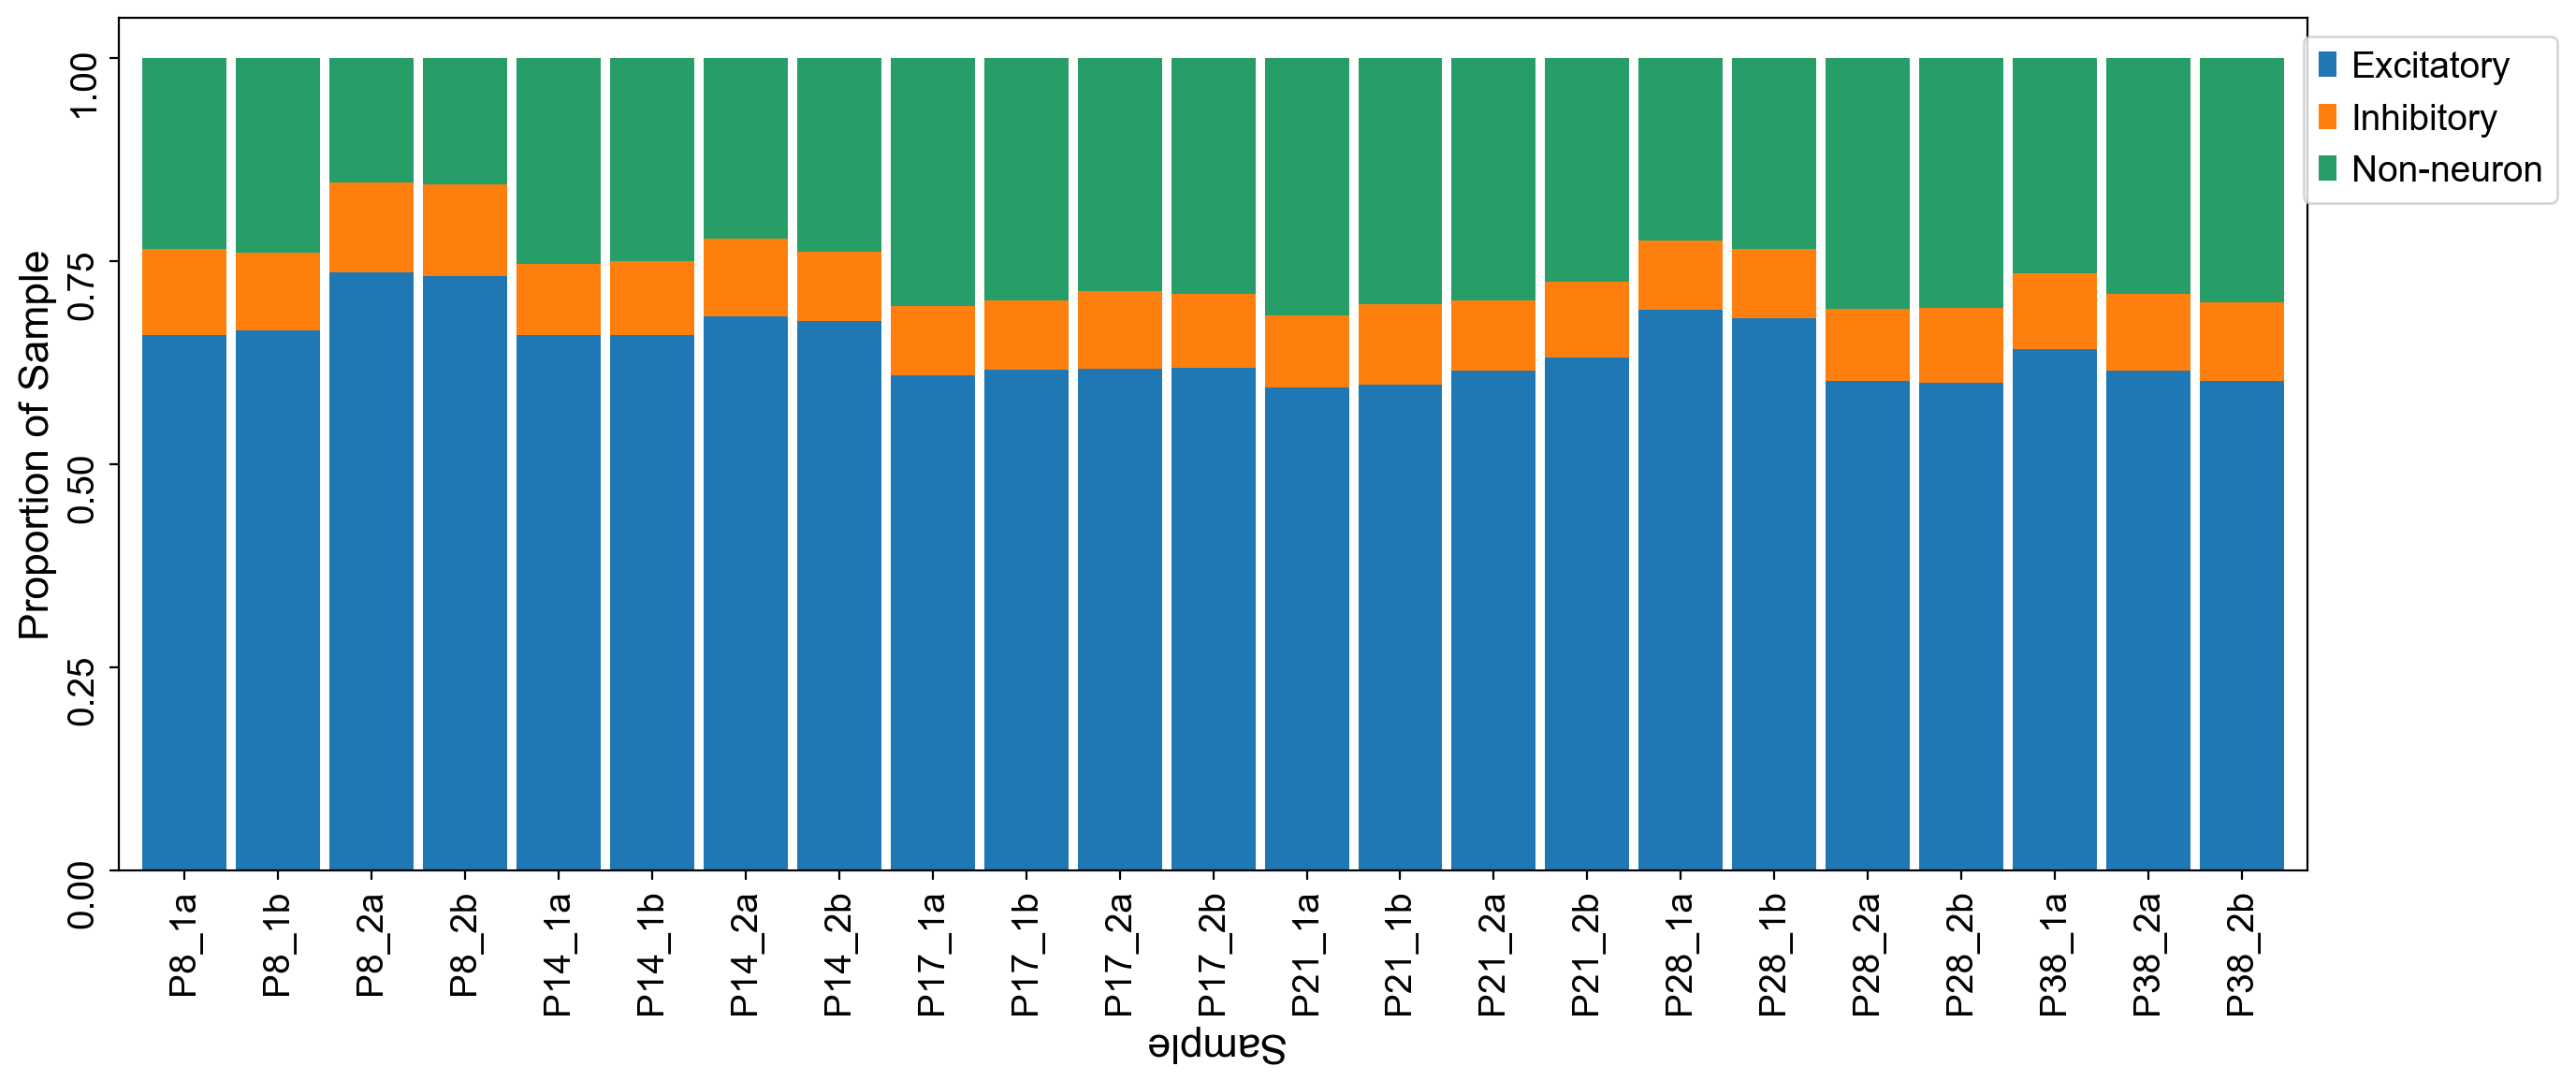

In [36]:
barplot_df.plot(
    kind = 'bar',
    stacked = True,
    mark_right = True,
    grid=False, linewidth=0.5, width=0.9, figsize=(14,6))
plt.legend(bbox_to_anchor=(0.99, 1), loc='upper left', fontsize=14, ncol=1)
plt.ylabel('Proportion of Sample', fontsize=16)
plt.xlabel('Sample', rotation='180', fontsize=16)
plt.yticks([0,0.25,0.50, 0.75, 1.00],rotation='90')
plt.xticks(rotation='90',)
plt.tight_layout()
plt.savefig('sample_dist_Fig1.pdf', dpi=200)
plt.show()

## Break up object

Make 3 objects: gluta, gaba, non-neurons then bring them here for analysis.

In [ ]:
#code

adata = sc.read_h5ad('/path/to/PooledMVC_clusteredPCA_dubs_classes_clean.h5ad')
print(' ')
print(adata)
print(' ')

gaba = adata[adata.obs['Class_broad']=='Inhibitory',:]
gluta = adata[adata.obs['Class_broad']=='Excitatory',:]

non = adata.copy()

non = non[non.obs['Class_broad']!='Inhibitory',:]
non = non[non.obs['Class_broad']!='Excitatory',:]

print(' ')

if (gaba.shape[0] + gluta.shape[0] + non.shape[0] == adata.shape[0]):
    print('Splitting successful')
else: print('failed')
    
    
print(' ')
gaba.write_h5ad('/path/to/gaba.h5ad')
gluta.write_h5ad('/path/to/gluta.h5ad')
non.write_h5ad('/path/to/non.h5ad')

Make 6 age objects for each class (gluta and gaba)

In [ ]:
adata_gaba = sc.read_h5ad('/path/to/gaba.h5ad')
adata_gluta = sc.read_h5ad('/path/to/gluta.h5ad')

ages = list(adata_gluta.obs.batch.values.categories)

#glut
for i in ages:
    PX_glut = adata_gluta[adata_gluta.obs.batch==i, :]
    del PX_glut.obsp
    del PX_glut.varm
    del PX_glut.obsm
    del PX_glut.uns
    PX_glut.X = PX_glut.raw.X
    PX_glut.write_h5ad('/path/to/' + i + 'glut_raw.h5ad')
    
#gaba
for i in ages:
    PX_gaba = adata_gaba[adata_gaba.obs.batch==i, :]
    del PX_gaba.obsp
    del PX_gaba.varm
    del PX_gaba.obsm
    del PX_gaba.uns
    PX_gaba.X = PX_gaba.raw.X
    PX_gaba.write_h5ad('/path/to/' + i + 'gaba_raw.h5ad')